In [44]:
from datasets import load_dataset
import faiss
import pandas as pd
import numpy as np
from transformers import AutoProcessor, TFCLIPModel
import tensorflow as tf
from constants import *
import utils
import

## Wiki dataset

In [25]:
en_data = load_dataset("wikipedia", "20220301.simple", cache_dir=SCRATCH_DIR + "/datasets", split="train")

Found cached dataset wikipedia (/scratch/vpaturu/temp/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


In [26]:
def process_data(data):
  data_array = data.split('\n')
  data_array = [x for x in data_array if len(x.split(' ')) > 5]
  return data_array

In [27]:
en_text = en_data["text"]

### Data Preprocessing

In [28]:
wiki_data = []
for text in en_text:
  wiki_data.extend(process_data(text))

In [29]:
print(len(wiki_data))

1103373


## Create embeddings

In [30]:
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = AutoProcessor.from_pretrained(clip_model_name, cache_dir=SCRATCH_DIR + "/processors")
clip_model = TFCLIPModel.from_pretrained(clip_model_name, cache_dir=SCRATCH_DIR + "/models")


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [32]:
if not os.path.exists('./data/clip_embeddings.npy'):
  all_embeddings = []
  batch_size = 10000

  for i in range(0, len(wiki_data), batch_size):
    print(i)
    batch = wiki_data[i:i+batch_size]
    inputs = clip_processor(text=batch, return_tensors="tf", padding=True, truncation=True)
    outputs = clip_model.get_text_features(**inputs)
    embeddings = outputs.numpy()
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    all_embeddings.append(embeddings)

  all_embeddings = np.concatenate(all_embeddings, axis=0)
  np.save("./data/clip_embeddings.npy", all_embeddings)
else:
  print("Loading embeddings")
  all_embeddings = np.load("./data/clip_embeddings.npy")


## Index embeddings

In [33]:
dim = all_embeddings.shape[1]
print(dim)

512


In [34]:
index = faiss.IndexFlatL2(dim)
index.is_trained

True

In [35]:
index.add(all_embeddings)

In [36]:
index.ntotal

1103373

In [37]:
# save the index
faiss.write_index(index, "./data/faiss_index.index")

# Testing

In [45]:
if not os.path.exists("./data/sentences.csv"):
  sentences_df = pd.DataFrame(wiki_data, columns=["sentence"])
  sentences_df.to_csv("./data/sentences.csv", index=False)
else:
  print("Sentences already saved")
  sentences_df = pd.read_csv("./data/sentences.csv")

Sentences already saved


In [49]:
dataset = load_dataset("Multimodal-Fatima/OK-VQA_train", cache_dir=SCRATCH_DIR+'/data')
train_set = dataset['train']

Found cached dataset parquet (/scratch/vpaturu/temp/data/Multimodal-Fatima___parquet/Multimodal-Fatima--OK-VQA_train-c49be14e3379d8e4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

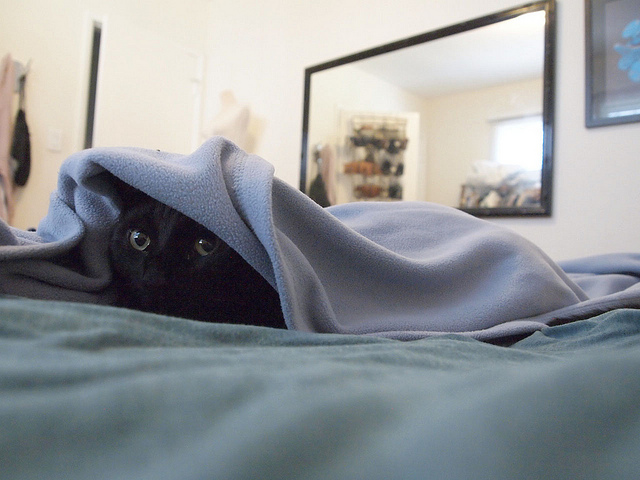

What animal is hiding?
What sort of animal is it? 
 Can you see the car?
In April, 2007, the D.C. Council approved Fenty's school takeover plan, and in May 2007, legislation needed to approve the change was passed by Congress and signed by President Bush. Under the new structure, the existing superintendent was replaced by a school chief, or chancellor, who was selected by the mayor and would report directly to him. This power shift also allowed the mayor to make swift changes in the system's central office, alter teacher qualification requirements, and implement a school consolidation process.  His selection of Michelle Rhee to manage District schools surprised many people. In choosing Rhee, he stepped outside of the local landscape to consult with national education experts including New York City School Chancellor Joel Klein.
 2001: The World Needs a Hero 
In 1928, the physicist Paul Dirac was looking for an equation that would predict how very fast particles should behave. There wa

In [57]:
random_id = np.random.randint(0, len(train_set))
sample = train_set[random_id]
display(sample['image'])
print(sample['question'])
context = utils.get_context(sample, index, sentences_df)
for sentence in context:
  print(sentence)